In [3]:
#import all libraries to be used in the exercise
import numpy as np
import pandas as pd
import os
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import display, Markdown, Image
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)


In [4]:
#show the files in the folder I´m working in. This will help me to check that I have the right files to load.
print(os.listdir()) 

['airline_loyalty_programme.csv', '.DS_Store', 'Customer Flight Activity.csv', 'modulo-3-evaluacion-elena.ipynb', 'Imagen', 'README.md', '.git', 'Customer Loyalty History.csv']


In [5]:
#Upload the files
df_flights = pd.read_csv('Customer Flight Activity.csv' , sep=',')
df_loyalty = pd.read_csv('Customer Loyalty History.csv' , sep=',')

In [6]:
#Show the construccion of each dataframe
print(df_flights.info())
print(df_loyalty.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               405624 non-null  int64  
 1   Year                         405624 non-null  int64  
 2   Month                        405624 non-null  int64  
 3   Flights Booked               405624 non-null  int64  
 4   Flights with Companions      405624 non-null  int64  
 5   Total Flights                405624 non-null  int64  
 6   Distance                     405624 non-null  int64  
 7   Points Accumulated           405624 non-null  float64
 8   Points Redeemed              405624 non-null  int64  
 9   Dollar Cost Points Redeemed  405624 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.9 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column     

In [7]:
#Verify the index of the dataframes is a custom index or a predefined numeric index
print(df_flights.index)
print(df_loyalty.index)

RangeIndex(start=0, stop=405624, step=1)
RangeIndex(start=0, stop=16737, step=1)


In [8]:
#Displays the first few rows of the dataframes so its structure can be checked
display(df_flights.head())
display(df_loyalty.head())

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0
3,100214,2017,1,0,0,0,0,0.0,0,0
4,100272,2017,1,0,0,0,0,0.0,0,0


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN


In [9]:
#Check if the columns names are correct
print(df_flights.columns)
print(df_loyalty.columns)

Index(['Loyalty Number', 'Year', 'Month', 'Flights Booked',
       'Flights with Companions', 'Total Flights', 'Distance',
       'Points Accumulated', 'Points Redeemed', 'Dollar Cost Points Redeemed'],
      dtype='object')
Index(['Loyalty Number', 'Country', 'Province', 'City', 'Postal Code',
       'Gender', 'Education', 'Salary', 'Marital Status', 'Loyalty Card',
       'CLV', 'Enrollment Type', 'Enrollment Year', 'Enrollment Month',
       'Cancellation Year', 'Cancellation Month'],
      dtype='object')


In [10]:
#Standardise column names in both dataframes, remove blank spaces, convert everything to lower case and replace spaces with underscores
df_flights.columns = df_flights.columns.str.strip().str.lower().str.replace(" ", "_")
df_loyalty.columns = df_loyalty.columns.str.strip().str.lower().str.replace(" ", "_")

print(df_flights.columns)
print(df_loyalty.columns)

Index(['loyalty_number', 'year', 'month', 'flights_booked',
       'flights_with_companions', 'total_flights', 'distance',
       'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed'],
      dtype='object')
Index(['loyalty_number', 'country', 'province', 'city', 'postal_code',
       'gender', 'education', 'salary', 'marital_status', 'loyalty_card',
       'clv', 'enrollment_type', 'enrollment_year', 'enrollment_month',
       'cancellation_year', 'cancellation_month'],
      dtype='object')


In [11]:
#Show how many unique values there are in each column of the dataframes
print("Number of unique values in Customer Flight Analysis:")
print(df_flights.nunique())

print("Number of unique values in Customer Loyalty History:")
print(df_loyalty.nunique())

Number of unique values in Customer Flight Analysis:
loyalty_number                 16737
year                               2
month                             12
flights_booked                    22
flights_with_companions           12
total_flights                     33
distance                        4746
points_accumulated              1549
points_redeemed                  587
dollar_cost_points_redeemed       49
dtype: int64
Number of unique values in Customer Loyalty History:
loyalty_number        16737
country                   1
province                 11
city                     29
postal_code              55
gender                    2
education                 5
salary                 5890
marital_status            3
loyalty_card              3
clv                    7984
enrollment_type           2
enrollment_year           7
enrollment_month         12
cancellation_year         6
cancellation_month       12
dtype: int64


In [12]:
print("unique values in columm year:", df_flights['year'].unique())
print("unique values in columm month:", df_flights['month'].unique())

unique values in columm year: [2017 2018]
unique values in columm month: [ 1  9  2  3 11  4  5  7  6  8 10 12]


In [13]:
#Check all the duplicated rows and count how many there are
print(df_flights.duplicated().sum())   #means that there are 1864 duplicated rows que the same values.
print(df_loyalty.duplicated().sum())

1864
0


In [14]:
df_flights[df_flights.duplicated(keep=False)].head(50)

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
41,101902,2017,1,0,0,0,0,0.0,0,0
42,101902,2017,1,0,0,0,0,0.0,0,0
226,112142,2017,1,0,0,0,0,0.0,0,0
227,112142,2017,1,0,0,0,0,0.0,0,0
477,126100,2017,1,0,0,0,0,0.0,0,0
478,126100,2017,1,0,0,0,0,0.0,0,0
566,130331,2017,1,0,0,0,0,0.0,0,0
567,130331,2017,1,0,0,0,0,0.0,0,0
659,135421,2017,1,0,0,0,0,0.0,0,0
660,135421,2017,1,0,0,0,0,0.0,0,0


In [15]:
#Remove duplicates that are exactly the same, removing the extra copies if all columns are the same
#and reset the index to avoid gaps after removing duplicates
df_flights.drop_duplicates(inplace=True)
df_flights.reset_index(drop=True, inplace=True)


In [16]:
#Run this code to check that the duplicates have been removed correctly. If it returns 0, there are no exact matches.
print(df_flights.duplicated().sum())


0


In [17]:
#To manage duplicates with differences in some columns, we search for records that have the same loyalty_number, year and month, 
#but with different values in other columns.
df_flights[df_flights.duplicated(subset=['loyalty_number', 'year', 'month'], keep=False)]

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
113,106001,2017,1,9,4,13,1365,136.0,0,0
114,106001,2017,1,5,0,5,910,91.0,0,0
273,114414,2017,1,8,4,12,3132,313.0,0,0
274,114414,2017,1,1,1,2,1094,109.0,0,0
485,126490,2017,1,6,0,6,1902,190.0,0,0
...,...,...,...,...,...,...,...,...,...,...
403437,981508,2018,12,5,5,10,4030,403.0,0,0
403587,990512,2018,12,15,5,20,2940,294.0,0,0
403588,990512,2018,12,5,2,7,3906,390.0,0,0
403622,992168,2018,12,15,0,15,3120,312.0,0,0


In [18]:
#Merge duplicate values
df_flights = df_flights.groupby(['loyalty_number', 'year', 'month']).agg({
    "flights_booked": "sum",
    "flights_with_companions": "sum",
    "total_flights": "sum",
    "distance": "sum",
    "points_accumulated": "sum",
    "points_redeemed": "sum",
    "dollar_cost_points_redeemed": "sum"}).reset_index()


In [19]:
#Select another option, like keeping only the rows with the most points. The code will be:
#df_flights = df_flights.sort_values(by='points_accumulated', ascending=False).drop_duplicates(subset=['loyalty_number', 'year', 'month'], keep='first')


In [20]:
print(df_flights.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401688 entries, 0 to 401687
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loyalty_number               401688 non-null  int64  
 1   year                         401688 non-null  int64  
 2   month                        401688 non-null  int64  
 3   flights_booked               401688 non-null  int64  
 4   flights_with_companions      401688 non-null  int64  
 5   total_flights                401688 non-null  int64  
 6   distance                     401688 non-null  int64  
 7   points_accumulated           401688 non-null  float64
 8   points_redeemed              401688 non-null  int64  
 9   dollar_cost_points_redeemed  401688 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.6 MB
None


In [21]:
#I am interested in seeing the unique values to test my hypothesis, even though we already know that there are no duplicates in the customer loyalty history.
text_columns = df_loyalty.select_dtypes(include=['object']).columns
for column_object in text_columns:
    print(f"The singles values of the column {column_object} are:")
    print(df_loyalty[column_object].unique())

The singles values of the column country are:
['Canada']
The singles values of the column province are:
['Ontario' 'Alberta' 'British Columbia' 'Quebec' 'Yukon' 'New Brunswick'
 'Manitoba' 'Nova Scotia' 'Saskatchewan' 'Newfoundland'
 'Prince Edward Island']
The singles values of the column city are:
['Toronto' 'Edmonton' 'Vancouver' 'Hull' 'Whitehorse' 'Trenton' 'Montreal'
 'Dawson Creek' 'Quebec City' 'Fredericton' 'Ottawa' 'Tremblant' 'Calgary'
 'Thunder Bay' 'Whistler' 'Peace River' 'Winnipeg' 'Sudbury'
 'West Vancouver' 'Halifax' 'London' 'Regina' 'Kelowna' "St. John's"
 'Victoria' 'Kingston' 'Banff' 'Moncton' 'Charlottetown']
The singles values of the column postal_code are:
['M2Z 4K1' 'T3G 6Y6' 'V6E 3D9' 'P1W 1K4' 'J8Y 3Z5' 'Y2K 6R0' 'P5S 6R4'
 'K8V 4B2' 'H2Y 2W2' 'M8Y 4K8' 'U5I 4F1' 'G1B 3L5' 'H4G 3T4' 'M2M 7K8'
 'M2M 6J7' 'E3B 2H2' 'M1R 4K3' 'T9G 1W3' 'H2Y 4R4' 'V5R 1W3' 'P1L 8X8'
 'K1F 2R2' 'H5Y 2S9' 'V1E 4R6' 'H2T 2J6' 'T3E 2V9' 'H2T 9K8' 'K8T 5M5'
 'V6T 1Y8' 'P2T 6G3' 'T9O 2

In [22]:
#The country column has only one value, which does not matter for me, so I will delete it.
df_loyalty.drop(columns=['country'], inplace=True)
print(df_loyalty.columns)

Index(['loyalty_number', 'province', 'city', 'postal_code', 'gender',
       'education', 'salary', 'marital_status', 'loyalty_card', 'clv',
       'enrollment_type', 'enrollment_year', 'enrollment_month',
       'cancellation_year', 'cancellation_month'],
      dtype='object')


In [23]:
#To avoid errors in further analysis, I will normalise columns with categorical values: gender, education, marital_status, loyalty_card and enrolment_type.
columns_to_standar = ['gender','education', 'marital_status', 'loyalty_card', 'enrollment_type']
df_loyalty[columns_to_standar] = df_loyalty[columns_to_standar].apply(lambda x: x.str.strip().str.lower())


In [24]:
for column in columns_to_standar:
    print(f"The singles values normalise of the column {column} are: {df_loyalty[column].unique()}")

The singles values normalise of the column gender are: ['female' 'male']
The singles values normalise of the column education are: ['bachelor' 'college' 'master' 'high school or below' 'doctor']
The singles values normalise of the column marital_status are: ['married' 'divorced' 'single']
The singles values normalise of the column loyalty_card are: ['star' 'aurora' 'nova']
The singles values normalise of the column enrollment_type are: ['standard' '2018 promotion']


In [25]:
#Once we have finished handling duplicates, we move on to managing nulls. 
#We have already seen that customer flight activity has no nulls, so we focus on customer loyalty history.
#First, we must see where there are nulls so we can decide how to deal with them.
df_loyalty.isnull().sum()


loyalty_number            0
province                  0
city                      0
postal_code               0
gender                    0
education                 0
salary                 4238
marital_status            0
loyalty_card              0
clv                       0
enrollment_type           0
enrollment_year           0
enrollment_month          0
cancellation_year     14670
cancellation_month    14670
dtype: int64

In [26]:
#We can calculate the percentage or make a bar chart to get an idea of the amount of nulls in the columns involved.
columns_with_nulls = ['salary', 'cancellation_year', 'cancellation_month']
nulls_ratio = np.round(df_loyalty[columns_with_nulls].isnull().mean()*100, 2)
print(nulls_ratio)

salary                25.32
cancellation_year     87.65
cancellation_month    87.65
dtype: float64


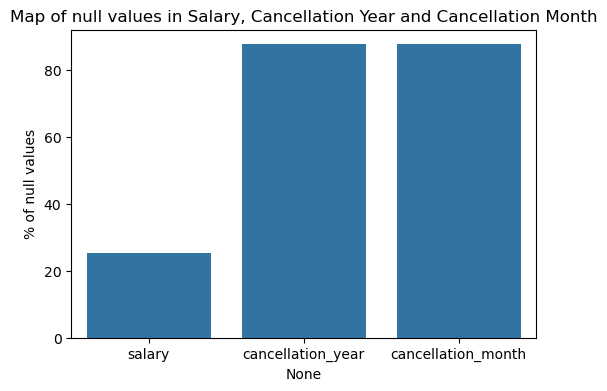

In [27]:
plt.figure(figsize=(6, 4))
sns.barplot(x=nulls_ratio.index, y=nulls_ratio.values)
plt.ylabel("% of null values")
plt.title("Map of null values in Salary, Cancellation Year and Cancellation Month")
plt.show()

In [28]:
#We can also run some basic statistics to better understand how the data's distributed or to help identify problems.
df_loyalty[['salary', 'cancellation_year', 'cancellation_month']].describe()

,salary,cancellation_year,cancellation_month
count,12499.000000,2067.000000,2067.000000
mean,79245.609409,2016.503145,6.962748
std,35008.297285,1.380743,3.455297
min,-58486.000000,2013.000000,1.000000
25%,59246.500000,2016.000000,4.000000
50%,73455.000000,2017.000000,7.000000
75%,88517.500000,2018.000000,10.000000
max,407228.000000,2018.000000,12.000000


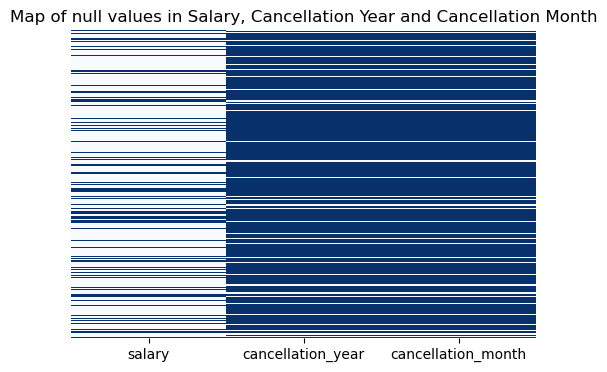

In [29]:
columns_with_nulls = ['salary', 'cancellation_year', 'cancellation_month']
plt.figure(figsize=(6, 4))
sns.heatmap(df_loyalty[columns_with_nulls].isnull(), cmap='Blues', cbar=False, yticklabels=False)
plt.title("Map of null values in Salary, Cancellation Year and Cancellation Month")
plt.show()

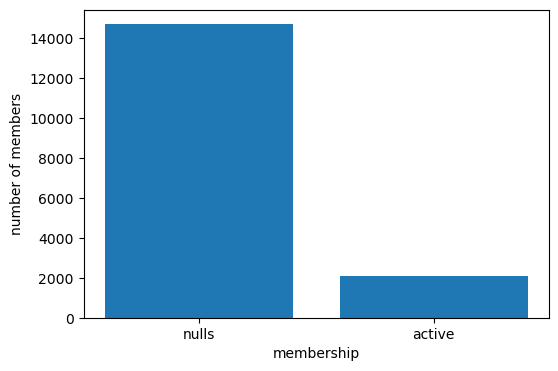

In [30]:
#Planteamos la hipotesis de que los clientes con valores nulos en cancellation year y cancellation month no son errores, si no que son clientes que siguen siendo activos en el porgrama de fidelidad.
cancelled_clients = df_loyalty[['cancellation_year', 'cancellation_month']].notnull().all(axis=1).value_counts()
plt.figure(figsize=(6,4))
plt.bar(["nulls", "active"], cancelled_clients.values)
plt.xlabel("membership")
plt.ylabel("number of members")
plt.show()



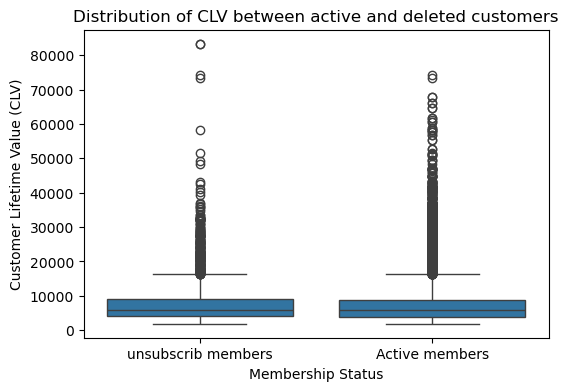

In [31]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_loyalty['cancellation_year'].isnull(), y=df_loyalty['clv'])
plt.xticks([0, 1], ["unsubscrib members", "Active members"])
plt.ylabel("Customer Lifetime Value (CLV)")
plt.xlabel("Membership Status")
plt.title("Distribution of CLV between active and deleted customers")
plt.show()


In [32]:
#We replace null values with 0 to avoid problems with further analysis. Always remember that 0 means that the client is still active.
df_loyalty['cancellation_year'] = df_loyalty['cancellation_year'].fillna(0)
df_loyalty['cancellation_month'] = df_loyalty['cancellation_month'].fillna(0)


In [33]:
#We check that the replacements have been executed correctly.
df_loyalty['cancellation_year'] = df_loyalty['cancellation_year'].astype(int)
df_loyalty['cancellation_month'] = df_loyalty['cancellation_month'].astype(int)
df_loyalty[['cancellation_year', 'cancellation_month']].info()
df_loyalty[['cancellation_year', 'cancellation_month']].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   cancellation_year   16737 non-null  int64
 1   cancellation_month  16737 non-null  int64
dtypes: int64(2)
memory usage: 261.6 KB


cancellation_year     0
cancellation_month    0
dtype: int64

In [34]:
negative_salaries = (df_loyalty['salary'] < 0).sum()
print(negative_salaries)

20


In [35]:
df_loyalty[df_loyalty['salary'] < 0]

,loyalty_number,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
1082,542976,Quebec,Montreal,H2Y 4R4,male,high school or below,-49830.0,divorced,star,24127.50,2018 promotion,2018,3,0,0
1894,959977,British Columbia,Vancouver,V5R 1W3,female,bachelor,-12497.0,married,aurora,9453.00,2018 promotion,2018,3,0,0
2471,232755,British Columbia,Vancouver,V1E 4R6,female,bachelor,-46683.0,single,nova,4787.81,2018 promotion,2018,3,0,0
3575,525245,British Columbia,Victoria,V10 6T5,male,bachelor,-45962.0,married,star,2402.33,2018 promotion,2018,3,0,0
3932,603070,British Columbia,West Vancouver,V6V 8Z3,female,bachelor,-19325.0,single,star,2893.74,2018 promotion,2018,3,0,0
4712,491242,British Columbia,Dawson Creek,U5I 4F1,male,bachelor,-43234.0,married,star,7597.91,2018 promotion,2018,3,0,0
6560,115505,Newfoundland,St. John's,A1C 6H9,male,bachelor,-10605.0,married,nova,5860.17,2018 promotion,2018,4,0,0
6570,430398,Newfoundland,St. John's,A1C 6H9,male,bachelor,-17534.0,married,nova,49423.80,2018 promotion,2018,3,0,0
7373,152016,Ontario,Toronto,P1J 8T7,female,bachelor,-58486.0,married,aurora,5067.21,2018 promotion,2018,2,0,0
8576,194065,Ontario,Sudbury,M5V 1G5,female,bachelor,-31911.0,married,nova,2888.85,2018 promotion,2018,2,0,0


In [36]:
df_loyalty.loc[df_loyalty['salary'] < 0, 'salary'] = np.nan

In [37]:
new_negative_salaries = (df_loyalty['salary'] < 0).sum()
print(new_negative_salaries)

0


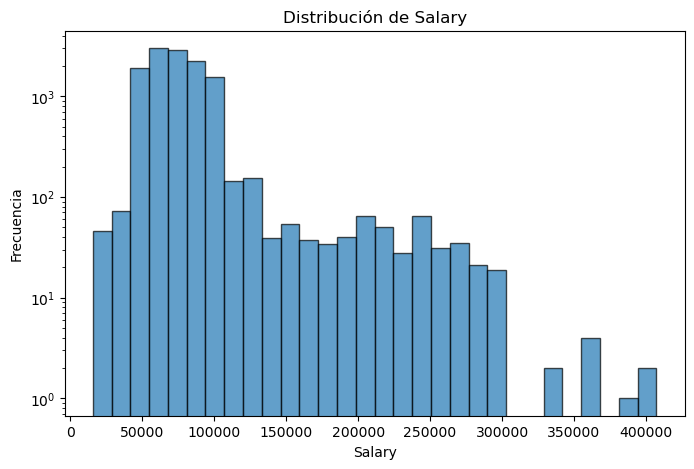

In [38]:

plt.figure(figsize=(8, 5))
plt.hist(df_loyalty['salary'].dropna(), bins=30, edgecolor='black', alpha=0.7, log=True)
plt.title("Distribución de Salary")
plt.xlabel("Salary")
plt.ylabel("Frecuencia")
plt.show()


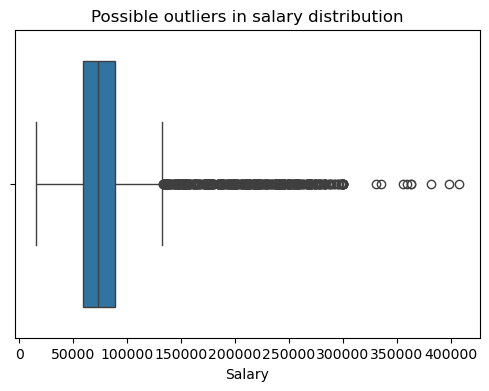

In [39]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_loyalty['salary'])
plt.xlabel("Salary")
plt.title("Possible outliers in salary distribution")
plt.show()


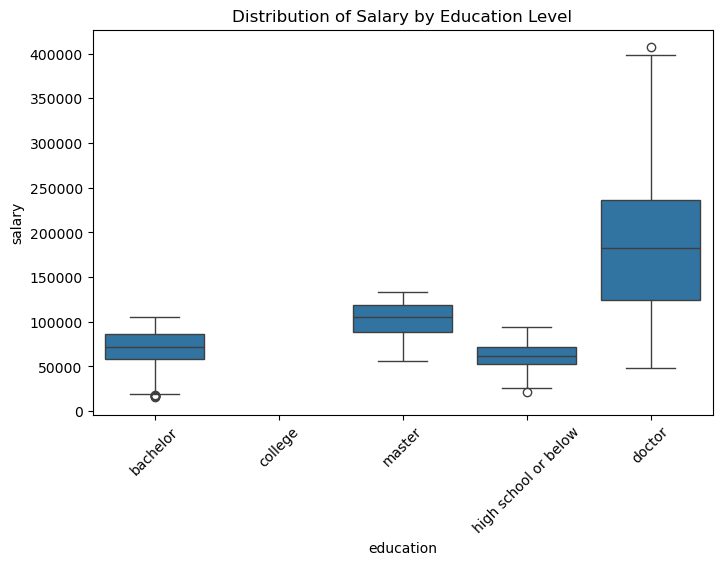

In [40]:
#To see how we can manage the null values in the salary column, we are going to make a series of comparisons with columns in the same table. 
#This will show us their relationship and whether they follow a pattern.
plt.figure(figsize=(8, 5))
sns.boxplot(x='education', y='salary', data=df_loyalty)
plt.xticks(rotation=45)
plt.title("Distribution of Salary by Education Level")
plt.show()



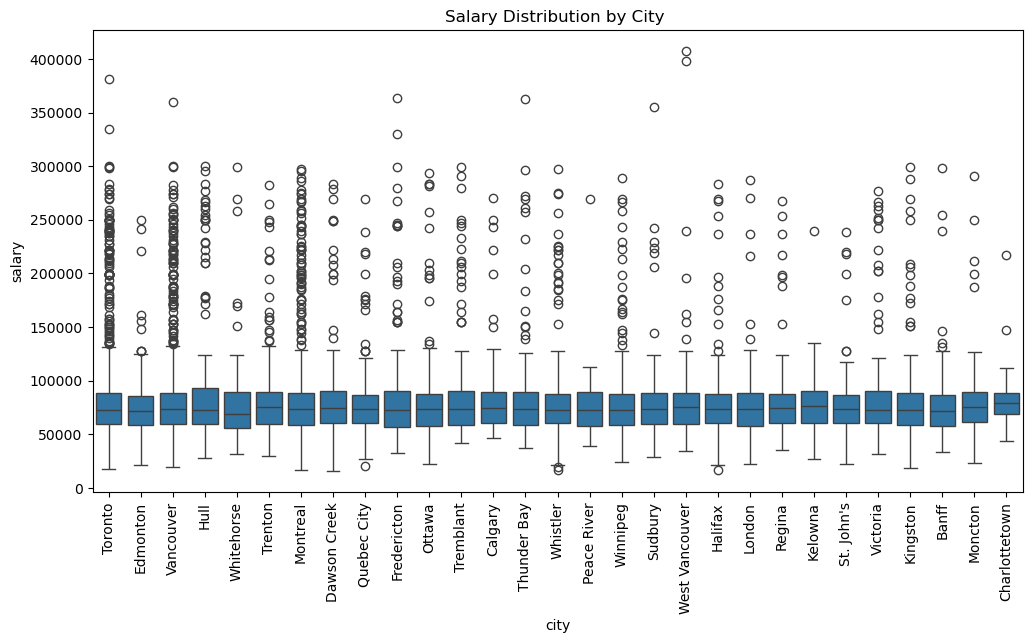

In [41]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='salary', data=df_loyalty)
plt.xticks(rotation=90)
plt.title("Salary Distribution by City ")
plt.show()


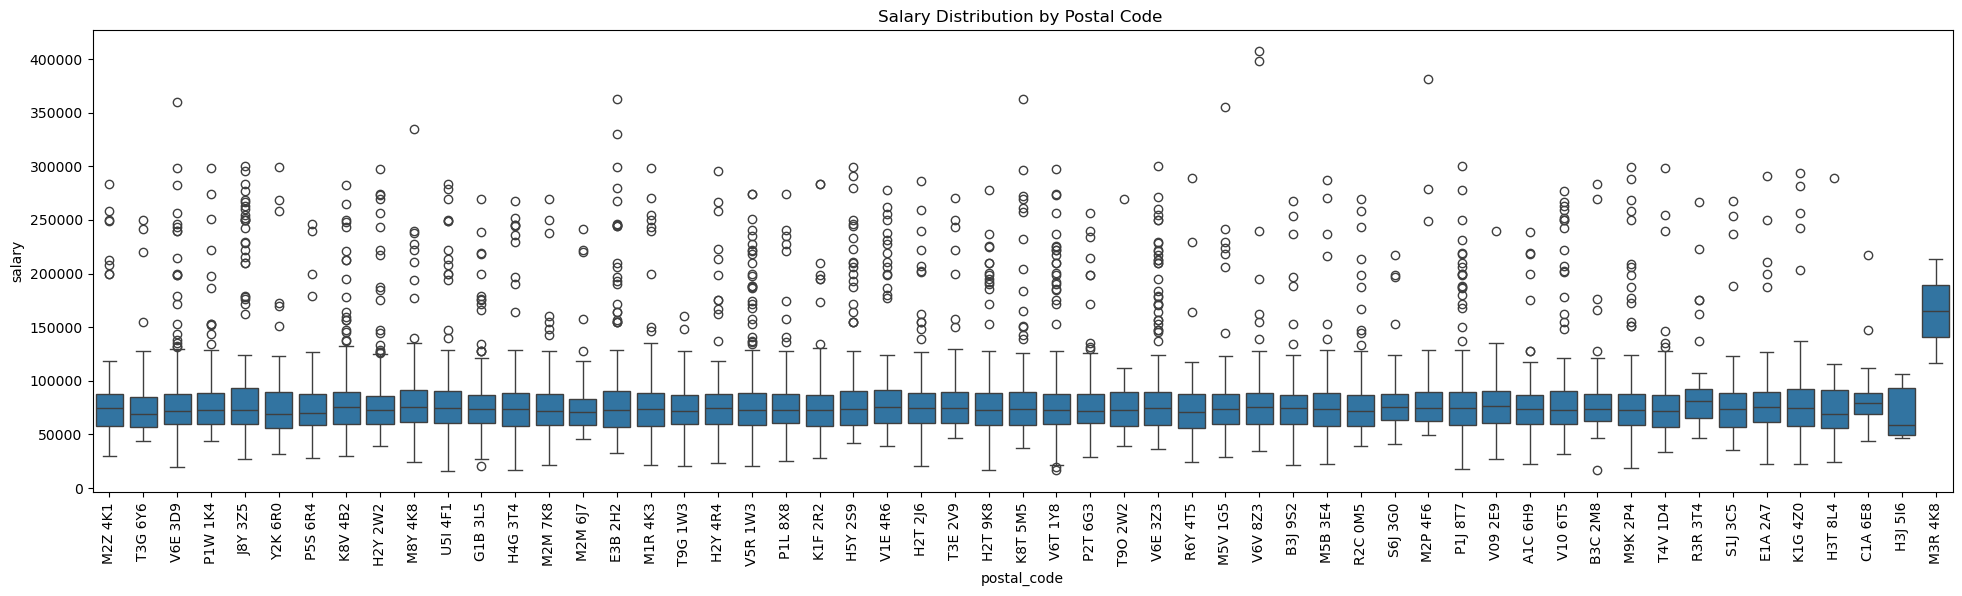

In [42]:
plt.figure(figsize=(24, 6))
sns.boxplot(x='postal_code', y='salary', data=df_loyalty)
plt.xticks(rotation=90)
plt.title("Salary Distribution by Postal Code ")
plt.show()


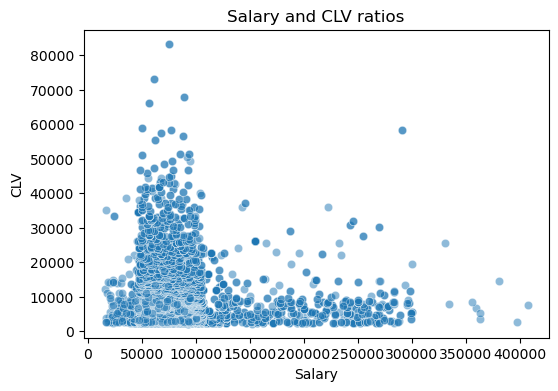

In [43]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='salary', y='clv', data=df_loyalty, alpha=0.5)
plt.xlabel("Salary")
plt.ylabel("CLV")
plt.title("Salary and CLV ratios")
plt.show()


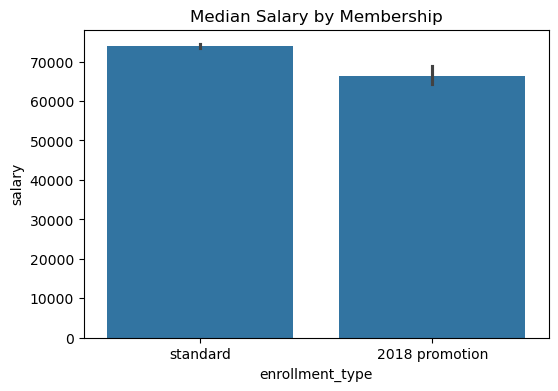

In [44]:
plt.figure(figsize=(6, 4))
sns.barplot(x='enrollment_type', y='salary', data=df_loyalty, estimator=np.median)
plt.title("Median Salary by Membership")
plt.show()


In [45]:
#To substitute missing values we will use IterativeImputer as it is the most complete method to replace null values.
#These models cannot use categorical values so we will map relevant columns such as education or postal code to numerical ones before executing this technique.
education_mapping ={'High School or Below': 0,
                    'college': 1,
                    'bachelor': 2,
                    'master': 3,
                    'doctor': 4}
df_loyalty['education_number'] = df_loyalty['education'].map(education_mapping)

df_loyalty['postal_code_number'], _ = df_loyalty['postal_code'].factorize()

In [46]:
df_loyalty[['education', 'education_number', 'postal_code', 'postal_code_number']].head(10)

,education,education_number,postal_code,postal_code_number
0,bachelor,2.0,M2Z 4K1,0
1,college,1.0,T3G 6Y6,1
2,college,1.0,V6E 3D9,2
3,college,1.0,P1W 1K4,3
4,bachelor,2.0,J8Y 3Z5,4
5,bachelor,2.0,Y2K 6R0,5
6,college,1.0,P5S 6R4,6
7,bachelor,2.0,K8V 4B2,7
8,bachelor,2.0,H2Y 2W2,8
9,bachelor,2.0,M8Y 4K8,9


In [47]:
print(df_loyalty.columns)


Index(['loyalty_number', 'province', 'city', 'postal_code', 'gender',
       'education', 'salary', 'marital_status', 'loyalty_card', 'clv',
       'enrollment_type', 'enrollment_year', 'enrollment_month',
       'cancellation_year', 'cancellation_month', 'education_number',
       'postal_code_number'],
      dtype='object')


In [48]:
df_loyalty[['salary', 'clv']].describe()

,salary,clv
count,12479.000000,16737.000000
mean,79429.572642,7988.896536
std,34727.560404,6860.982280
min,15609.000000,1898.010000
25%,59265.000000,3980.840000
50%,73510.000000,5780.180000
75%,88600.500000,8940.580000
max,407228.000000,83325.380000


In [49]:

colums_imputer = ['salary', 'clv', 'education_number', 'postal_code_number']
imputer = IterativeImputer(max_iter=100, random_state=42)
df_loyalty[colums_imputer] = imputer.fit_transform(df_loyalty[colums_imputer])

In [50]:
df_loyalty['salary'].isnull().sum()


0

In [51]:
df_loyalty[['salary', 'clv']].describe()

,salary,clv
count,16737.000000,16737.000000
mean,79440.828958,7988.896536
std,29987.536121,6860.982280
min,15609.000000,1898.010000
25%,63991.000000,3980.840000
50%,79286.398771,5780.180000
75%,82940.000000,8940.580000
max,407228.000000,83325.380000


In [52]:
#we remove the columns that we have converted to numerical columns as we no longer need them.
df_loyalty.drop(columns=['education_number', 'postal_code_number'], inplace=True)


In [53]:
#We will join the dataframes using the loyalty_number column. 
#We want to keep all the clients of df_loyalty and add the data of df_flights. So we will make a merge left join.
df_merged = df_loyalty.merge(df_flights, on='loyalty_number', how="left")

In [54]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401688 entries, 0 to 401687
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loyalty_number               401688 non-null  int64  
 1   province                     401688 non-null  object 
 2   city                         401688 non-null  object 
 3   postal_code                  401688 non-null  object 
 4   gender                       401688 non-null  object 
 5   education                    401688 non-null  object 
 6   salary                       401688 non-null  float64
 7   marital_status               401688 non-null  object 
 8   loyalty_card                 401688 non-null  object 
 9   clv                          401688 non-null  float64
 10  enrollment_type              401688 non-null  object 
 11  enrollment_year              401688 non-null  int64  
 12  enrollment_month             401688 non-null  int64  
 13 

In [55]:
df_merged.sample(20)

,loyalty_number,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
31944,468542,British Columbia,Vancouver,V5R 1W3,male,bachelor,87848.000000,married,aurora,5111.30,2018 promotion,2018,4,2018,12,2017,1,0,0,0,0,0.0,0,0
1237,869743,Ontario,Sudbury,M5V 1G5,female,bachelor,73236.000000,single,star,3924.42,standard,2016,11,2017,7,2018,2,0,0,0,0,0.0,0,0
109144,747668,Quebec,Tremblant,H5Y 2S9,female,bachelor,96992.000000,single,nova,2909.55,standard,2016,7,0,0,2018,5,13,0,13,3484,348.0,0,0
277048,375792,Ontario,Kingston,M9K 2P4,male,bachelor,73135.000000,single,star,2674.73,standard,2017,11,0,0,2018,5,4,4,8,752,75.0,0,0
203188,856074,British Columbia,Whistler,V6T 1Y8,female,college,79343.723618,married,nova,9117.44,standard,2012,5,0,0,2017,5,11,0,11,3762,376.0,0,0
312724,925433,Ontario,Toronto,P2T 6G3,female,bachelor,58637.000000,married,star,4762.16,standard,2015,8,0,0,2017,5,3,0,3,3357,335.0,0,0
86937,807769,Nova Scotia,Halifax,B3C 2M8,female,bachelor,49952.000000,married,aurora,15483.53,standard,2015,4,0,0,2017,10,13,1,14,2324,232.0,0,0
56603,950660,British Columbia,Victoria,V10 6T5,male,college,79439.239236,divorced,aurora,8007.40,standard,2015,11,0,0,2017,12,7,5,12,3564,356.0,0,0
134070,721438,Quebec,Montreal,H4G 3T4,male,bachelor,88425.000000,single,nova,4045.34,standard,2016,5,0,0,2017,7,0,0,0,0,0.0,0,0
5521,228580,Ontario,Toronto,M8Y 4K8,male,bachelor,54643.000000,single,star,4305.79,standard,2012,5,0,0,2017,2,0,0,0,0,0.0,0,0


In [56]:
#Export the new clean dataset to a CSV file
df_merged.to_csv("airline_loyalty_programme.csv", index=False)
print(os.listdir()) 

['airline_loyalty_programme.csv', '.DS_Store', 'Customer Flight Activity.csv', 'modulo-3-evaluacion-elena.ipynb', 'Imagen', 'README.md', '.git', 'Customer Loyalty History.csv']


In [57]:
#there are columns that for the visualisation phase we don't care if they are joined, so let's proceed to join them.
df_merged['enrollment_date'] = pd.to_datetime(df_merged['enrollment_year'].astype(str) + '-' + df_merged['enrollment_month'].astype(str) + '-01', format="%Y-%m-%d")
df_merged =df_merged.drop(columns=['enrollment_year', 'enrollment_month'])
col_position = df_merged.columns.get_loc('cancellation_year')
df_merged.insert(col_position, 'enrollment_date', df_merged.pop('enrollment_date'))
df_merged = df_merged.set_index('loyalty_number')
df_merged.sample(15)



,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_date,cancellation_year,cancellation_month,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
loyalty_number,,,,,,,,,,,,,,,,,,,,,,
679908,Quebec,Montreal,H4G 3T4,female,bachelor,77601.000000,married,star,3921.02,standard,2015-08-01,0,0,2017,6,17,0,17,3859,385.00,0,0
537387,Ontario,Toronto,M2P 4F6,male,bachelor,62259.000000,married,star,3746.75,standard,2015-06-01,0,0,2018,6,12,0,12,4920,492.00,0,0
452439,British Columbia,Vancouver,V6E 3D9,male,college,79609.141281,married,aurora,6032.74,standard,2015-11-01,0,0,2017,7,9,0,9,2691,269.00,0,0
288451,Nova Scotia,Halifax,B3J 9S2,male,bachelor,63708.000000,married,nova,5065.94,standard,2017-09-01,2018,1,2018,4,0,0,0,0,0.00,0,0
605849,New Brunswick,Fredericton,E3B 2H2,male,bachelor,51553.000000,married,star,7295.43,standard,2017-01-01,0,0,2018,4,12,4,16,3424,369.36,0,0
627869,British Columbia,Victoria,V10 6T5,female,college,79891.285406,married,nova,2753.78,standard,2013-01-01,2016,1,2017,8,0,0,0,0,0.00,0,0
369242,Newfoundland,St. John's,A1C 6H9,female,master,75891.000000,divorced,aurora,10083.49,standard,2016-03-01,0,0,2017,11,13,7,20,1520,152.00,0,0
455896,Ontario,Toronto,P1W 1K4,male,bachelor,66226.000000,married,star,2580.85,standard,2013-01-01,0,0,2018,2,0,0,0,0,0.00,0,0
244099,Ontario,Toronto,M2M 7K8,female,college,79709.746621,married,star,4863.54,2018 promotion,2018-02-01,0,0,2017,4,0,0,0,0,0.00,0,0


### ❓ Question 1: Distribution of the number of flights booked per month during each year

In [58]:
flights_month_and_year =df_flights.groupby(['year', 'month'])['flights_booked'].sum().reset_index()
print(flights_month_and_year)

    year  month  flights_booked
0   2017      1           47766
1   2017      2           47691
2   2017      3           64271
3   2017      4           55720
4   2017      5           65279
5   2017      6           80493
6   2017      7           89288
7   2017      8           78692
8   2017      9           63304
9   2017     10           60351
10  2017     11           56905
11  2017     12           77650
12  2018      1           49170
13  2018      2           48643
14  2018      3           66928
15  2018      4           56791
16  2018      5           76891
17  2018      6           92749
18  2018      7          104143
19  2018      8           90512
20  2018      9           73075
21  2018     10           69110
22  2018     11           65345
23  2018     12           88397


📈 **Why do we use this chart?**  
A line chart is useful when we want to see trends or fluctuations over time. In this case, we are interested in seeing how the number of flights changes month by month, and a line connecting them will help us identify peaks in specific months.  


🔍  **What does the chart tell us?**

The graph shows the distribution of booked flights per month during the years 2017 and 2018.  
A seasonal trend is evident, with a progressive increase from February to July, followed by a decline from August to November.  
July is the month with the highest number of bookings, indicating high summer demand.  
Another peak occurs in December, likely due to the holiday or year-end season.  
2018 shows a higher number of bookings in all months compared to 2017.  


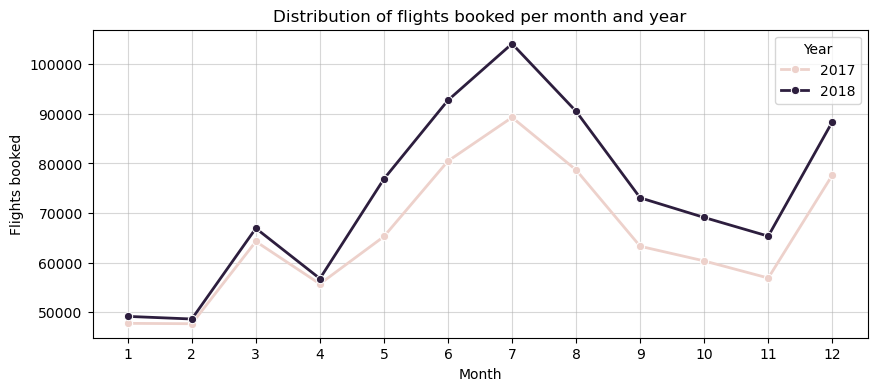

In [59]:
flights_month_and_year =df_flights.groupby(['year', 'month'])['flights_booked'].sum().reset_index()
plt.figure(figsize=(10,4))
sns.lineplot(x='month', y='flights_booked', hue='year', data=flights_month_and_year, marker="o", linewidth=2, markersize=6)
plt.title("Distribution of flights booked per month and year")
plt.xticks(ticks=range(1, 13))
plt.xlabel("Month")
plt.ylabel("Flights booked")
plt.legend(title='Year')
plt.grid(True, alpha=0.5)


📉 **Why do we use this chart?**  
A bar chart helps us compare the number of flights per month in a structured way. It clearly shows the differences between months.  

🔍  **What does the chart tell us?**

This graph represents the same data but in bar format.  
It confirms the increase in flight bookings during summer and December.  
The bars for 2018 are consistently higher than those for 2017, confirming the overall growth in reservations.  
The difference between the two years is most noticeable in June, July, and December—key months for the airline’s growth.  

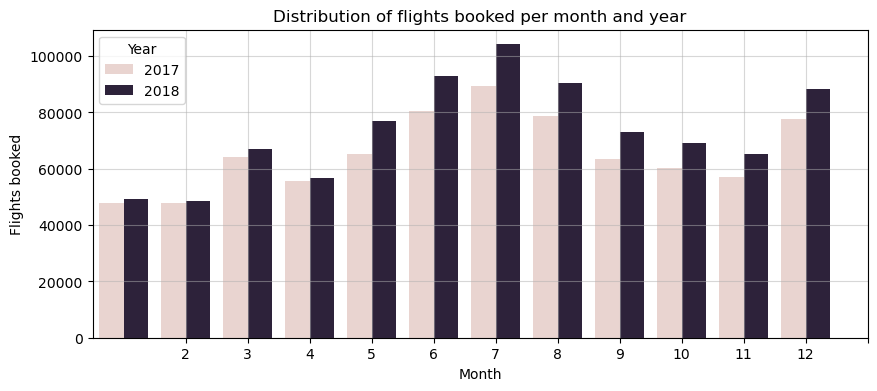

In [60]:
flights_month_and_year =df_flights.groupby(['year', 'month'])['flights_booked'].sum().reset_index()
plt.figure(figsize=(10,4))
sns.barplot(x='month', y='flights_booked', hue='year', data=flights_month_and_year)
plt.title("Distribution of flights booked per month and year")
plt.xticks(ticks=range(1, 13))
plt.xlabel("Month")
plt.ylabel("Flights booked")
plt.legend(title='Year')
plt.grid(True, alpha=0.5)

🔚  **Summing-up**

Both graphs confirm a seasonal booking pattern and the overall growth in 2018 compared to 2017.  

💬  ***Strategy for the Company***

- **Optimize pricing and special offers.**  
- **Introduce discounts or promotions** during low-demand months to stimulate bookings.  
- **Adjust high-demand fares** to maximize revenue.  
- **Increase flight frequency** during peak season to take advantage of demand.  
- **Plan aircraft maintenance** during the low season to ensure operational efficiency in peak months.   

**-------------------------------------------**

### ❓ Question 2: Is there a connection between flight distance and points accumulated?

📈 **Why do we use this chart?**  
A scatter plot helps us visualize how individual points are distributed and whether there is a relationship between them.  

🔍 **What Does the Chart Tell Us?**

The graph shows the relationship between flight distance and accumulated points, differentiating between the three types of loyalty cards (Star, Nova, and Aurora).

We observe a clear relationship: the greater the distance, the more flight points are accumulated.

Different Slopes Observed
- Star (purple points) appears to grant fewer points per distance traveled.
- Aurora (orange points) seems to accumulate more points than Star.
- Nova (pink points) is the card that accumulates the most points per distance, which could indicate that it is the highest-tier card.

There are some outliers, with accumulated points significantly higher than the general distance trend.



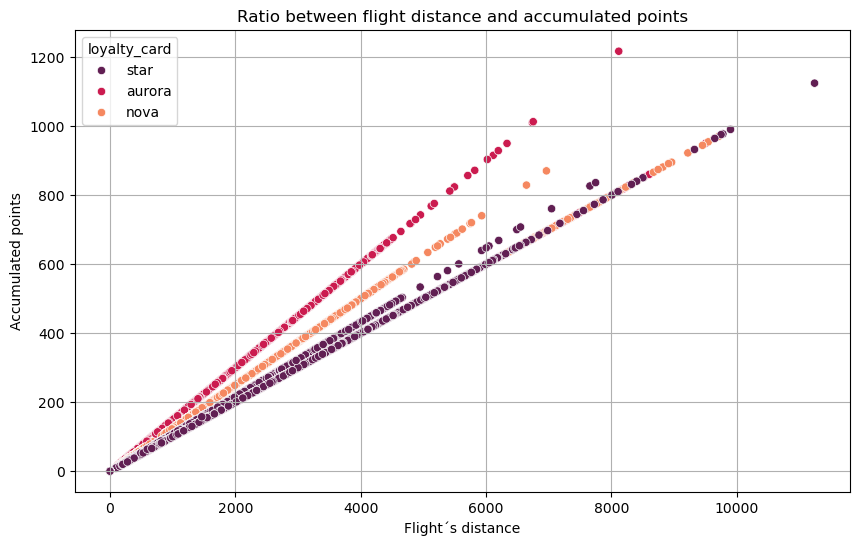

In [61]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="distance", y="points_accumulated", hue="loyalty_card", data= df_merged, marker="o", palette="rocket")
plt.xlabel("Flight´s distance")
plt.ylabel("Accumulated points")
plt.title("Ratio between flight distance and accumulated points")
plt.grid(True)


📉 **Why do we use this chat?**  
A linear regression plot adds a regression line to the scatter plot, helping us see if there is a trend and to separate variables to analyze specific patterns.  


🔍 **What Does the Chart Tell Us?**

It is confirmed that there is a direct relationship between miles traveled and accumulated points.
It is also confirmed that the loyalty cards differ by status, with Star accumulating the fewest points, Aurora being an intermediate category, and Nova being the premium category.

Text(0.5, 1.0, 'Ratio between flight distance and accumulated points')

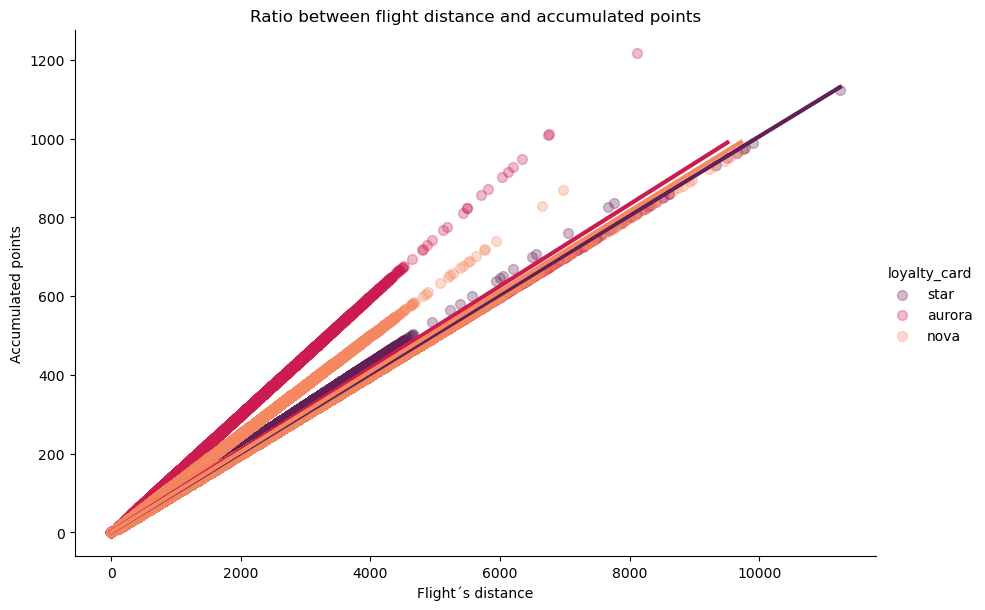

In [62]:
sns.lmplot(x="distance", y="points_accumulated", hue="loyalty_card", data=df_merged, markers="o", height=6, aspect=1.5, palette="rocket", scatter_kws={"alpha": 0.3, "s": 50}, line_kws={"linewidth":3})
plt.xlabel("Flight´s distance")
plt.ylabel("Accumulated points")
plt.title("Ratio between flight distance and accumulated points")

🔚 **Summing-up**

Both graphs show that distance directly influences the number of points. Higher-tier customers (Nova) receive greater rewards for the same distance traveled.

💬  **Strategy for the Company**

Optimizing the Loyalty Program:

Evaluate whether the differences between loyalty cards are attractive enough to encourage customers to fly more or upgrade their level.

Introduce double points accumulation bonuses during specific low-season periods.

Create exclusive promotions that allow long-haul flights to accumulate more points, encouraging customers to choose the airline for transoceanic flights.

Implement bonus points campaigns in low-demand months for lower-tier customers.

**---------------------------------------------------------**

### ❓ Question 3: What is the distribution of clients by province and state?

In [63]:
members_province = df_loyalty["province"].value_counts()
print(members_province)


province
Ontario                 5404
British Columbia        4409
Quebec                  3300
Alberta                  969
Manitoba                 658
New Brunswick            636
Nova Scotia              518
Saskatchewan             409
Newfoundland             258
Yukon                    110
Prince Edward Island      66
Name: count, dtype: int64


📈 **Why do we use this chart?**  
A bar chart is very clear for comparing the number of clients in each province. 

🔍  **What does the chart tell us?**

We observe the number of customers distributed by province, with a strong concentration in Ontario, BC, and Quebec. On the other hand, provinces like Prince Edward Island, Yukon, and Newfoundland have a significantly lower share compared to the main regions.  
This suggests that the airline has a highly concentrated geographical presence.  

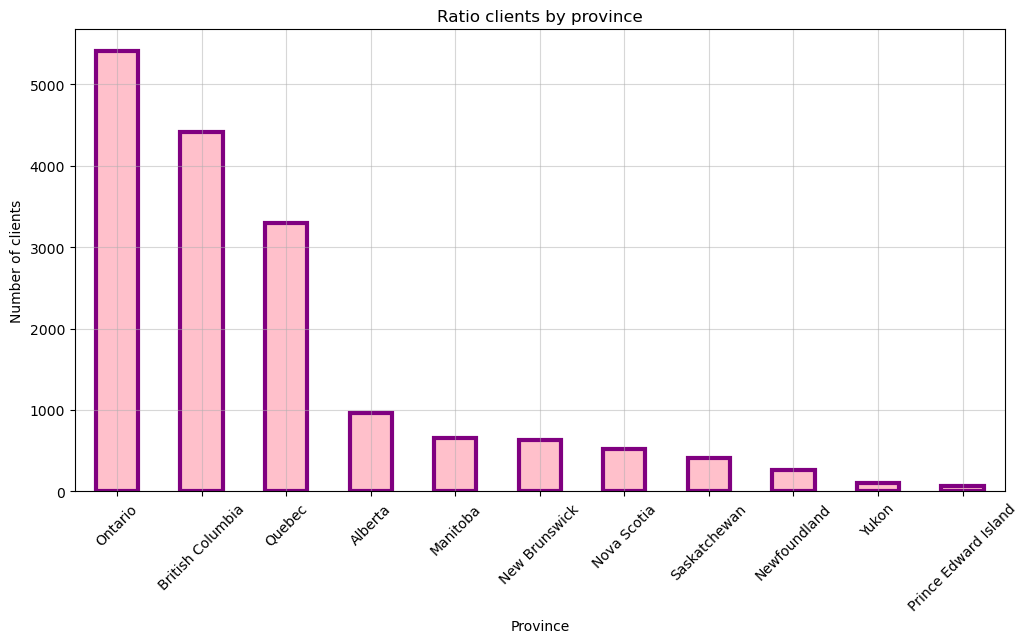

In [64]:
plt.figure(figsize=(12, 6))
members_province.plot(kind="bar", color="pink", edgecolor="purple", linewidth=3)
plt.xlabel("Province")
plt.xticks(rotation=45)
plt.ylabel("Number of clients")
plt.title("Ratio clients by province")
plt.grid(True, alpha=0.5)


📊 **Why do we use this chart?**  
By flipping the chart and adding percentages, interpretation becomes easier, and it is useful if the number of clients varies significantly between provinces.  

🔍  **What does the chart tell us?**

Representing the relative proportion of customers in each province instead of the absolute number helps us compare it with the total population distribution in Canada (according to the 2021 Census) and assess the loyalty program's penetration in each province.  
Provinces with a negative result, such as Ontario, Quebec, or Alberta, indicate lower program penetration. This could suggest a lack of incentives or lower interest due to strong competition. Additionally, Alberta is one of the wealthiest provinces in Canada, presenting a significant opportunity to attract new customers.  
BC’s high ratio indicates strong success in the region.  
Smaller provinces show a participation level similar to their population proportion.  


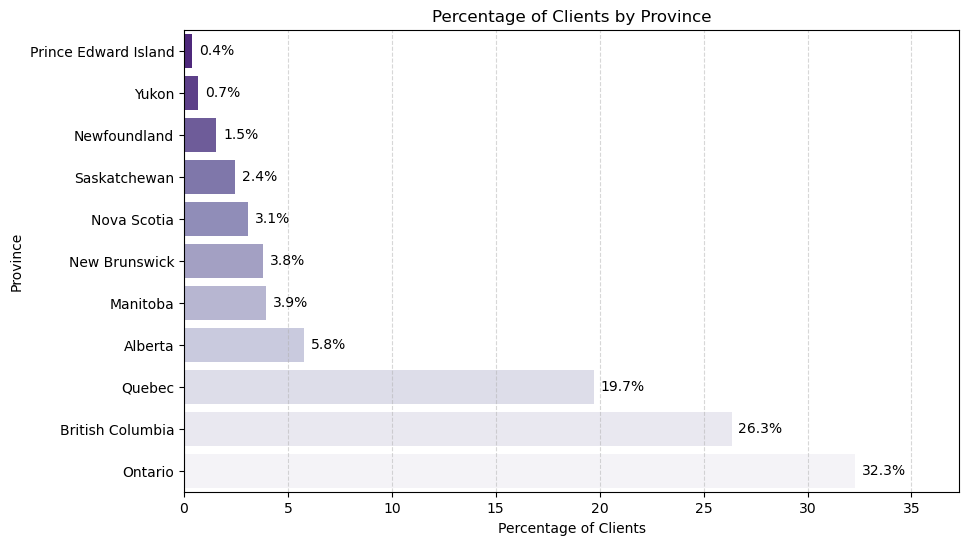

In [65]:
members_percentage = (members_province / members_province.sum()) * 100
members_percentage = members_percentage.sort_values(ascending=True)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=members_percentage, y=members_percentage.index, palette="Purples_r")
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=5, fontsize=10)
plt.xlabel("Percentage of Clients")
plt.ylabel("Province")
plt.title("Percentage of Clients by Province")
plt.xlim(0, max(members_percentage) + 5) 
plt.grid(axis="x", linestyle="--", alpha=0.5)



📉 **Why do we use this chart?**  
The variable 'salary' is displayed in a violin plot, which provides a visual representation of the distribution of salaries across each province. The wider the graph points in an area, the higher the concentration of individuals earning that particular salary in that province..  

🔍  **What does the chart tell us?**

It is interesting to analyze the salary range according to the population of each province. Ontario, Alberta, and BC have the widest salary distribution. These provinces have a diverse customer base due to their large populations and strong economies.  
Manitoba and New Brunswick have smaller economies, resulting in less salary dispersion.  
Yukon, however, shows a broad salary distribution due to its diversified economy, geographical location, and small population.  

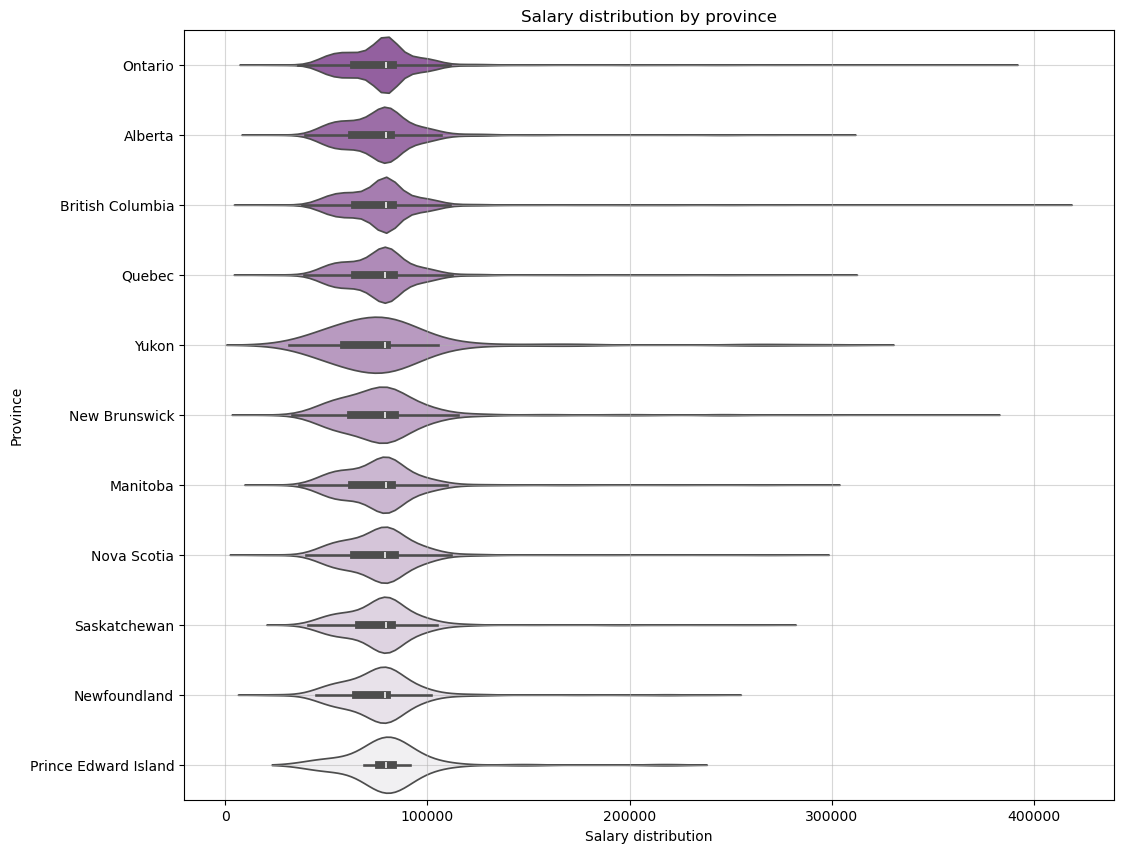

In [66]:
plt.figure(figsize=(12, 10))
sns.violinplot(y="province", x="salary", data=df_loyalty, palette="light:#95A_r", scale="width")
plt.xlabel("Salary distribution")
plt.ylabel("Province")
plt.title("Salary distribution by province")
plt.grid(True, alpha=0.5)
plt.show()

### Canada Data

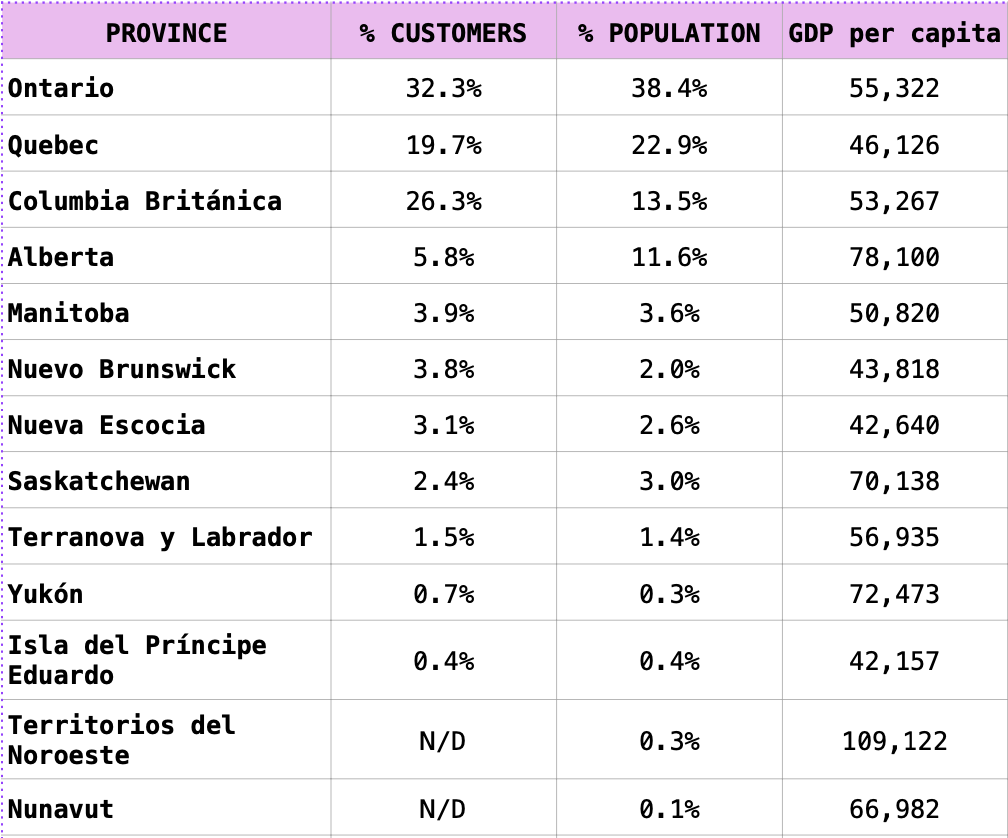

In [67]:
from IPython.display import display, Markdown, Image

display(Markdown("### Canada Data"))
display(Image("Imagen/2025-03-10.png", width=400, height=300))

🔚  **Summing-up**

Most customers come from three key provinces: Ontario, BC, and Quebec, which together account for 78.3% of the customer base. These regions also exhibit a broader salary distribution, indicating higher purchasing power.  
The fact that the loyalty program's penetration is not proportional to each province’s population suggests opportunities for expansion and the need for province-specific strategies. 


💬  ***Strategy for the Company***

**Expand the loyalty program’s presence** in Ontario, Quebec, and Alberta by offering exclusive benefits at airports or launching targeted communication campaigns in key sectors like business and tourism.  
**Leverage BC’s success** and strengthen customer loyalty. Analyze what has worked well in BC to determine if similar strategies can be implemented in other provinces.  
**Increase representation in underperforming provinces** by introducing personalized incentives such as regional flight discounts, new route development, or collaborations with local governments.  

**----------------------------------------------**

### ❓ Question 4: Compare the average salary by education level

In [68]:
salary_by_education = df_loyalty.groupby("education")["salary"].mean().round(2).sort_values()
print(salary_by_education)


education
high school or below     61235.25
bachelor                 72658.07
college                  79474.76
master                  103757.85
doctor                  178608.90
Name: salary, dtype: float64


📊 **Why do we use this chart?**  
A bar chart helps us clearly compare the average salary for each education level.  

🔍  **What does the chart tell us?**

The chart indicates that, in general, a higher level of education corresponds to a higher average salary. Additionally, the difference between intermediate levels (bachelor's and college) is smaller compared to the gap between a master's and a doctorate.

One important detail is that, in Canada, college and bachelor's refer to two different levels of post-secondary education. College typically includes technical education programs (similar to vocational training or associate degrees in other countries, such as diplomatura or FP in Spain), whereas a bachelor's degree corresponds to a full university degree.

Therefore, this difference in average salaries may be influenced by the technical nature of college programs, in contrast to the more academic training provided by bachelor's degrees.

([0, 1, 2, 3, 4],
 [Text(0, 0, 'high school or below'),
  Text(1, 0, 'bachelor'),
  Text(2, 0, 'college'),
  Text(3, 0, 'master'),
  Text(4, 0, 'doctor')])

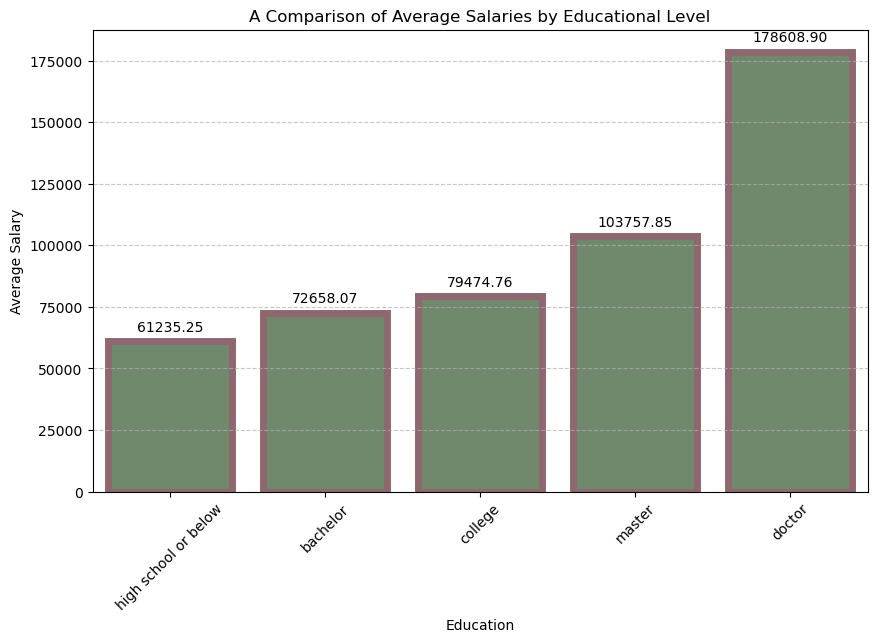

In [69]:
df_salary = salary_by_education.reset_index() 
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_salary, x="education", y="salary", color="#6C8E68", edgecolor="#8e686e", linewidth=5)
ax.bar_label(ax.containers[0], fmt="%.2f", fontsize=10, color="black", padding=5)
plt.xlabel("Education")
plt.ylabel("Average Salary")
plt.title("A Comparison of Average Salaries by Educational Level")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)


📈 **Why do we use this chart?**  
A boxplot also allows us to see the full distribution of salaries within each education level, as well as outliers.  

🔍  **What does the chart tell us?**

The salary range for college is more uniform, indicating that salaries tend to be consistent across the board with minimal variance.

In contrast, the Bachelor's degree salary range exhibits significant dispersion, likely attributable to the wide range of salaries achievable with university qualifications. These outliers suggest that, in certain cases, these professionals can attain remarkably high salaries.

The high school distribution is relatively concentrated, with minimal income dispersion. Some outliers may be attributed to extended career trajectories or entrepreneurial endeavours.

([0, 1, 2, 3, 4],
 [Text(0, 0, 'bachelor'),
  Text(1, 0, 'college'),
  Text(2, 0, 'master'),
  Text(3, 0, 'high school or below'),
  Text(4, 0, 'doctor')])

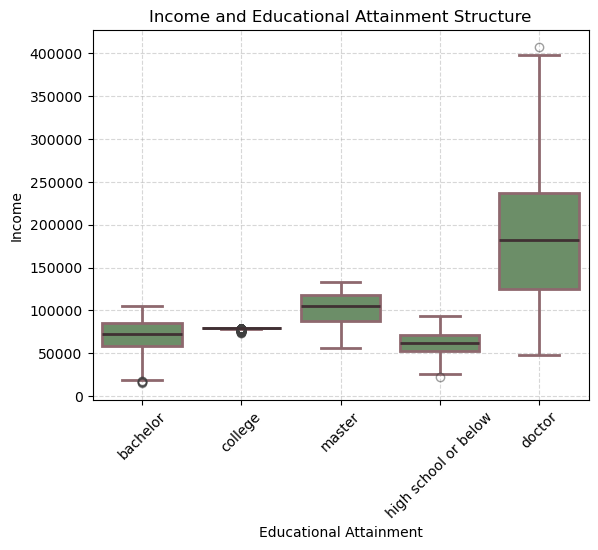

In [70]:

sns.boxplot(x=df_loyalty["education"], y=df_loyalty["salary"], 
            boxprops={"facecolor": "#6C8E68", "edgecolor": "#8E686E", "linewidth": 2},
            medianprops={"color": "#403033", "linewidth": 2},  
            whiskerprops={"color": "#8E686E", "linewidth": 2}, 
            capprops={"color": "#8E686E", "linewidth": 2},
            flierprops={"marker": "o", "color": "#8E686E", "alpha": 0.5})  
plt.xlabel("Educational Attainment")
plt.ylabel("Income")
plt.title("Income and Educational Attainment Structure")
plt.grid(True, alpha=0.5, linestyle="--")
plt.xticks(rotation=45)





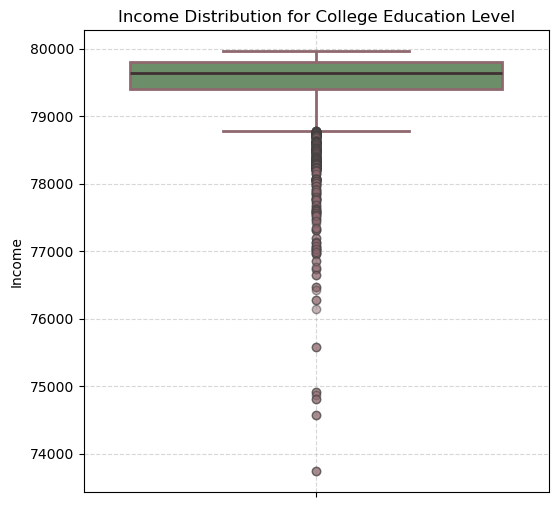

In [71]:
#We are going to see the same graph only with the college data in order to see it properly.
df_college = df_loyalty[df_loyalty["education"] == "college"]
plt.figure(figsize=(6, 6))
sns.boxplot(y=df_college["salary"], 
            boxprops={"facecolor": "#6C8E68", "edgecolor": "#8E686E", "linewidth": 2},
            medianprops={"color": "#403033", "linewidth": 2},
            whiskerprops={"color": "#8E686E", "linewidth": 2},  # Bigotes
            capprops={"color": "#8E686E", "linewidth": 2},
            flierprops={"marker": "o", "markerfacecolor": "#8E686E", "alpha": 0.5})
plt.ylabel("Income")
plt.title("Income Distribution for College Education Level")
plt.grid(True, alpha=0.5, linestyle="--")

📊 **Why do we use this chart?**  
A bar chart is a useful tool for visualising wage data. By breaking down wages into specific ranges and displaying the number of customers in each range, it provides clear insights into the distribution of wages.

🔍  **What does the chart tell us?**

The salary range for college is more unifor

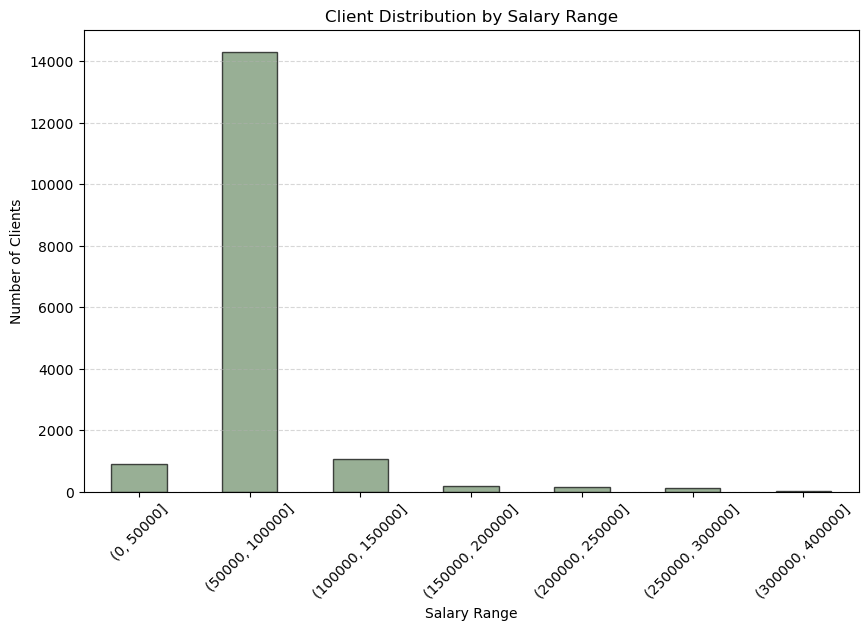

In [84]:
salary_bins = [0, 50000, 100000, 150000, 200000, 250000, 300000, 400000]
df_loyalty["salary_range"] = pd.cut(df_loyalty["salary"], bins=salary_bins)
plt.figure(figsize=(10,6))
df_loyalty["salary_range"].value_counts().sort_index().plot(kind="bar", color="#6C8E68", edgecolor="black", alpha=0.7)
plt.xlabel("Salary Range")
plt.ylabel("Number of Clients")
plt.title("Client Distribution by Salary Range")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.5, linestyle="--")
plt.show()


🔚 **Summing-up**

As a general guideline we can define that higher education opens the door to higher salaries, but only a small percentage of people reach extremely high levels. PhDs have the highest salary dispersion which can be interesting for premium strategies. It is very important to note that most of the loyalty programme base is focused on a single salary range.

💬  **Strategy for the Company**

It would be beneficial to create targeted promotions based on educational attainment and salary stability. 
For example, college and bachelor customers could be offered benefits such as points accumulation, promotions on domestic flights, or discounts on work routes. 
For customers with master's and doctoral degrees, we could define premium services, priority access, or other exclusive loyalty programmes.

Given that the majority of customers are in the mid-range, it is essential to focus efforts on benefits that are accessible to the majority of customers, as they are the ones who sustain the programme, with flexible fares and incentives for distance-based loyalty.

**--------------------------------------------------**

### ❓ Question 5: What is the percentage of clients for each type of loyalty card?


In [73]:
loyalty_counts = df_loyalty["loyalty_card"].value_counts(normalize=True) * 100
print(loyalty_counts)


loyalty_card
star      45.629444
nova      33.883014
aurora    20.487543
Name: proportion, dtype: float64


📈 **Why do we use this chart?**  
A pie chart is useful because it shows the proportion of each type of card. It is very intuitive.  

🔍  **What does the chart tell us?**


(-1.0999999564316005,
 1.0999994574331056,
 -1.0999967245123503,
 1.0999927623090937)

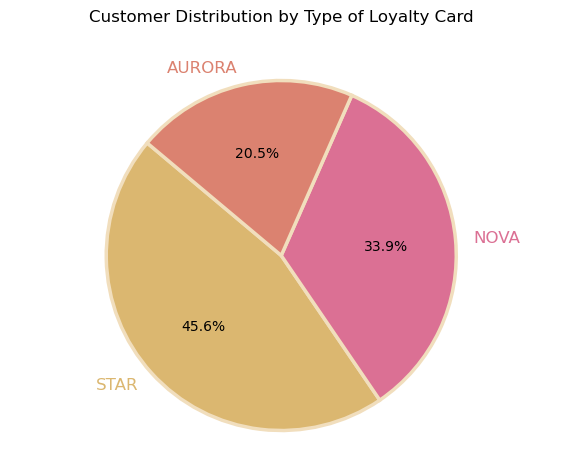

In [74]:
plt.figure(figsize=(7, 5))
colors = ["#dbb770", "#db7094", "#db8270", "gold"]
wedges, texts, autotexts = plt.pie(loyalty_counts, labels=loyalty_counts.index, autopct="%1.1f%%", colors=colors, startangle=140, wedgeprops={"edgecolor": "#f1debd", "linewidth": 2.5})
for text, color in zip(texts, colors):
    text.set_text(text.get_text().upper()) 
    text.set_color(color) 
    text.set_fontsize(12) 
plt.title("Customer Distribution by Type of Loyalty Card", pad=30)
plt.axis("equal")

🔚 **Summing-up**

💬  **Strategy for the Company**

**------------------------------------------------**

### ❓ Question 6: How are clients distributed according to marital status and gender?

In [75]:

marital_gender_counts = df_loyalty.groupby(["marital_status", "gender"]).size().unstack()
print(marital_gender_counts)


gender          female  male
marital_status              
divorced          1269  1249
married           4869  4866
single            2272  2212


📊 **Why do we use this chart?**  
A bar plot clearly shows how many clients belong to each marital status and their gender distribution.  

🔍  **What does the chart tell us?**


<Figure size 600x400 with 0 Axes>

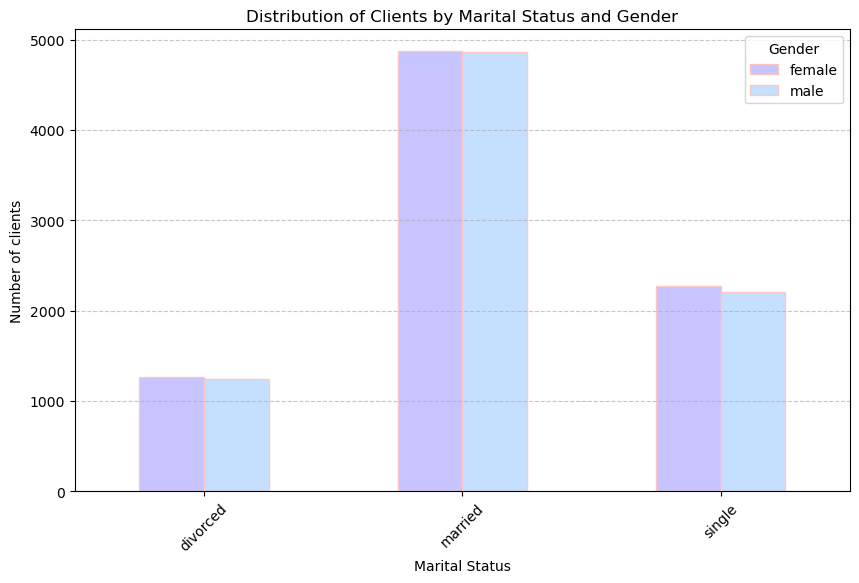

In [76]:
plt.figure(figsize=(6, 4))
marital_gender_counts.plot(kind="bar", figsize=(10, 6), color=["#c7c4ff", "#c4dfff"], edgecolor="#ffc7c4")
plt.xlabel("Marital Status")
plt.ylabel("Number of clients")
plt.title("Distribution of Clients by Marital Status and Gender")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.grid(axis="y", linestyle="--", alpha=0.7)


📉 **Why do we use this chart?**  
If we remove the gender variable, a pie chart quickly shows the distribution of clients by marital status only.  

🔍  **What does the chart tell us?**

(-1.1244185575237204,
 1.1426540376449084,
 -1.1497654509060464,
 1.1506150827291621)

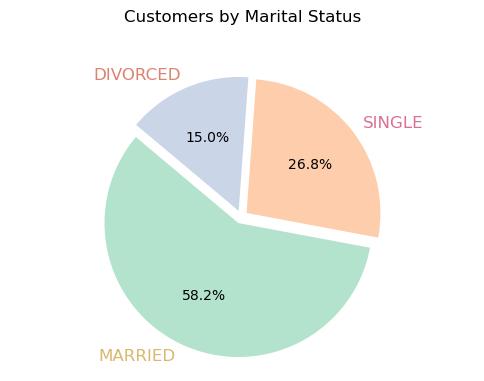

In [77]:
marital_counts = df_loyalty["marital_status"].value_counts()
plt.figure(figsize=(6, 4))
explode = [0.05] * len(marital_counts)
wedges, texts, autotexts = plt.pie(marital_counts, labels=marital_counts.index, autopct="%1.1f%%", colors=plt.cm.Pastel2.colors, startangle=140, explode=explode)
for text, color in zip(texts, colors):
    text.set_text(text.get_text().upper()) 
    text.set_color(color) 
    text.set_fontsize(12) 
plt.title("Customers by Marital Status", pad=30)
plt.axis("equal")

📈 **Why do we use this chart?**  
By integrating a numerical variable like `salary`, we can use a violin plot to visualize the salary distribution within each marital status. 
This helps analyze whether the loyalty program presents salary inequalities between men and women within each marital category.  

🔍  **What does the chart tell us?**

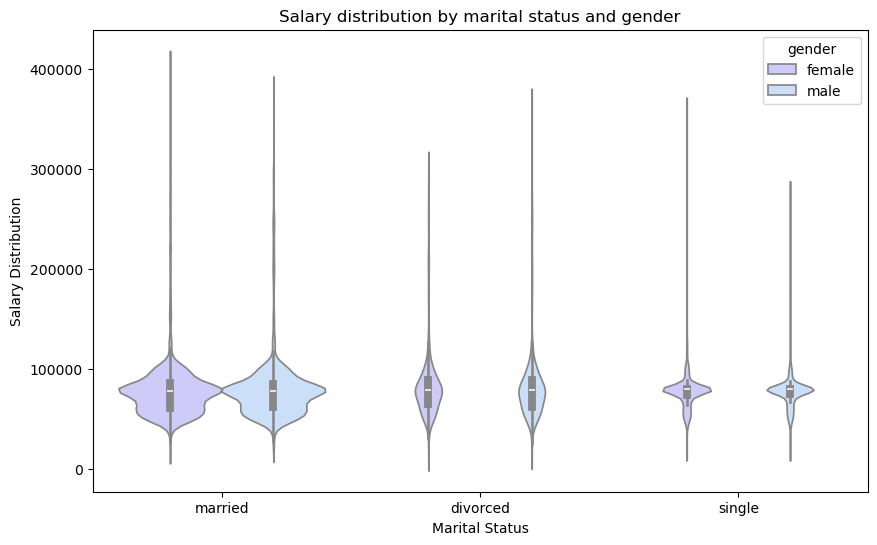

In [78]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="marital_status", y="salary", hue="gender", data=df_loyalty, palette=["#c7c4ff", "#c4dfff"], scale="count")
plt.xlabel("Marital Status")
plt.ylabel("Salary Distribution")
plt.title("Salary distribution by marital status and gender")
plt.show()

🔚 **Summing-up**

💬  **Strategy for the Company**

**-------------------------------------------------**